In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from astropy import units as u
from astropy import constants as c
from astropy.time import Time

from sunpy.data import cache
from sunpy.coordinates import spice, frames
from sunpy.net import Fido
from sunpy.net.cdaweb import get_datasets
from sunpy.net.cdaweb import get_observatory_groups
from sunpy.time import parse_time
from sunpy.net import attrs as a
from sunpy.timeseries import TimeSeries

from sw_functions import download_sc_dataset, get_trajectory

/Users/nathan/.pyenv/versions/3.13.7/envs/sun_capstone/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
psp_mag = pd.read_pickle('data/psp_mag_rtn_1hour')
# Get trajectory data
psp_traj, psp_obstime = get_trajectory(psp_mag, 'psp')

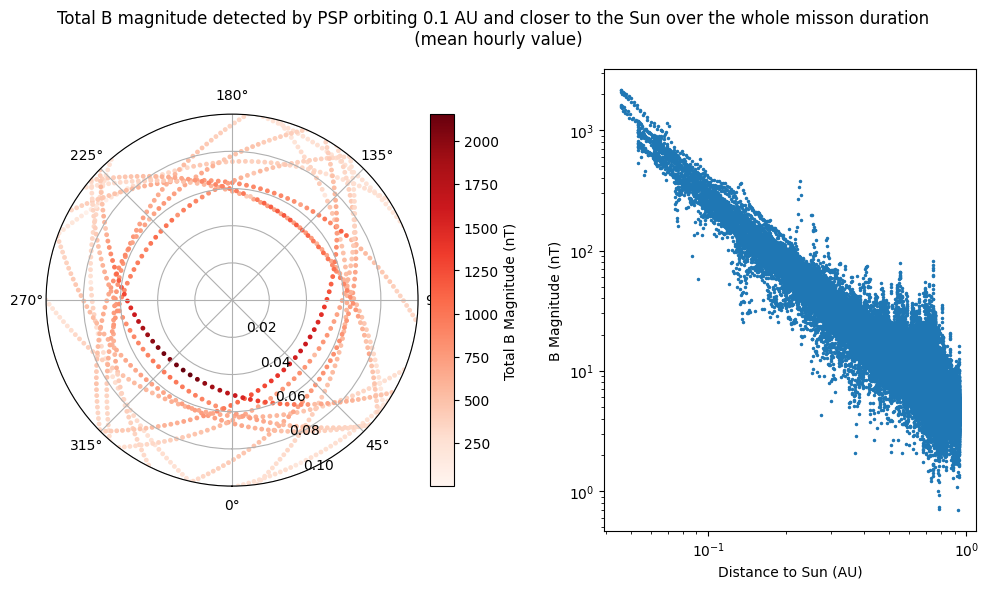

In [4]:
fig = plt.figure(figsize=(12, 6), dpi=100)

gs = GridSpec(1, 2, figure=fig, wspace=.5)

ax1 = fig.add_subplot(gs[0], projection='polar')
ax2 = fig.add_subplot(gs[1])

im = ax1.scatter(psp_traj.lon.to(u.rad), psp_traj.radius.to(u.au), s=6, label="Parker Solar Probe", c=psp_mag['total_B'], cmap="Reds")

fig.suptitle('Total B magnitude detected by PSP orbiting 0.1 AU and closer to the Sun over the whole misson duration \n (mean hourly value)')

ax1.set_theta_zero_location("S")
ax1.set_rmax(0.10)
#ax1.legend(loc='lower left')

cax = fig.add_axes([ax1.get_position().x1+0.01,ax1.get_position().y0,0.02,ax1.get_position().height])
fig.colorbar(im, cax=cax, label='Total B Magnitude (nT)')

ax2.loglog(psp_traj.radius.to('AU'), psp_mag['total_B'], '.', ms='3')
ax2.set_ylabel('B Magnitude (nT)')
ax2.set_xlabel('Distance to Sun (AU)');